# Graded Exercise 7

Building on the given solution of CW7 part 1, we will explore and compare the effects of low frequency and high frequency features in image reconstruction.

1- Implement a dataset with high pass filtered and original images from the dataset.

2- Train the U-Net with different high frequency filtering width and report SSIM's compared to the original images. The goal is to find the width that provides a similar SSIM quality with low pass of cutoff_frequency=8. Compare the total number of frequency components (pixels in the Fourier domain) for low and high pass filtering cases with the similar SSIM score. Comment on which approach (high or low pass filtering) is more efficient and why.

3- By using the given classifier network, check accuracies with full resolution, high pass filtered and U-Net output images from the validation set.


In [1]:
# !pip install piq

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
from piq import SSIMLoss



# Load the data
f = np.load('celeba.npz')
imgs = f['imgs'].swapaxes(0, 2)  # Assuming images are in [H, W, N] format

In [14]:
# Define LowPassFilter
class LowPassFilter(object):
    def __init__(self, cutoff_frequency):
        self.cutoff_frequency = cutoff_frequency

    def __call__(self, img):
        if isinstance(img, PIL.Image.Image):
            img = np.array(img)

        if len(img.shape) == 3:
            img = np.mean(img, axis=2)

        f_img = np.fft.fftshift(np.fft.fft2(img))

        rows, cols = img.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.ones((rows, cols), np.uint8)
        mask[crow-self.cutoff_frequency:crow+self.cutoff_frequency,
             ccol-self.cutoff_frequency:ccol+self.cutoff_frequency] = 0

        f_img_filtered = f_img * mask

        img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(f_img_filtered)))
        img_back = (img_back - img_back.min()) / (img_back.max() - img_back.min())

        return PIL.Image.fromarray((img_back * 255).astype(np.uint8))

# Define transforms
low_pass_transform = transforms.Compose([
    transforms.ToPILImage(),
    LowPassFilter(cutoff_frequency=2),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

original_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

# Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, imgs,labels):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        img = self.imgs[idx, :, :]
        img_input = low_pass_transform(img)
        img_target = original_transform(img)
        return img_input, img_target, self.labels[idx]

# Initialize dataset
dataset = ImageDataset(imgs,f['labels'])
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# UNet model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(1, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Conv2d(256, 128, 3, padding=1)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Conv2d(128, 64, 3, padding=1)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = F.relu(self.enc1(x))
        e2 = F.relu(self.enc2(self.pool(e1)))
        e3 = F.relu(self.enc3(self.pool(e2)))

        d1 = F.relu(self.up1(e3))
        d1 = torch.cat([d1, e2], dim=1)
        d1 = F.relu(self.dec1(d1))

        d2 = F.relu(self.up2(d1))
        d2 = torch.cat([d2, e1], dim=1)
        d2 = F.relu(self.dec2(d2))

        return F.sigmoid(self.final(d2))

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)



In [15]:
criterion = SSIMLoss(data_range = 1.0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for img_in, img_out,label in train_loader:
        img_in, img_out = img_in.to(device), img_out.to(device)

        optimizer.zero_grad()
        output = model(img_in)
        loss = criterion(output, img_out)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img_in, img_out,label in val_loader:
            img_in, img_out = img_in.to(device), img_out.to(device)
            output = model(img_in)
            loss = criterion(output, img_out)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss/len(train_loader):.6f}, "
          f"Val Loss: {val_loss/len(val_loader):.6f}")

 10%|█         | 1/10 [00:06<01:01,  6.87s/it]

Epoch [1/10], Train Loss: 0.741192, Val Loss: 0.703230


 20%|██        | 2/10 [00:13<00:53,  6.70s/it]

Epoch [2/10], Train Loss: 0.671564, Val Loss: 0.663772


 30%|███       | 3/10 [00:19<00:46,  6.57s/it]

Epoch [3/10], Train Loss: 0.621761, Val Loss: 0.607935


 40%|████      | 4/10 [00:26<00:39,  6.62s/it]

Epoch [4/10], Train Loss: 0.590383, Val Loss: 0.589678


 50%|█████     | 5/10 [00:32<00:32,  6.48s/it]

Epoch [5/10], Train Loss: 0.566816, Val Loss: 0.570649


 60%|██████    | 6/10 [00:39<00:26,  6.55s/it]

Epoch [6/10], Train Loss: 0.551172, Val Loss: 0.559058


 70%|███████   | 7/10 [00:45<00:19,  6.45s/it]

Epoch [7/10], Train Loss: 0.532383, Val Loss: 0.552320


 80%|████████  | 8/10 [00:52<00:13,  6.54s/it]

Epoch [8/10], Train Loss: 0.520689, Val Loss: 0.537493


 90%|█████████ | 9/10 [00:58<00:06,  6.42s/it]

Epoch [9/10], Train Loss: 0.507909, Val Loss: 0.527420


100%|██████████| 10/10 [01:05<00:00,  6.53s/it]

Epoch [10/10], Train Loss: 0.498576, Val Loss: 0.518939


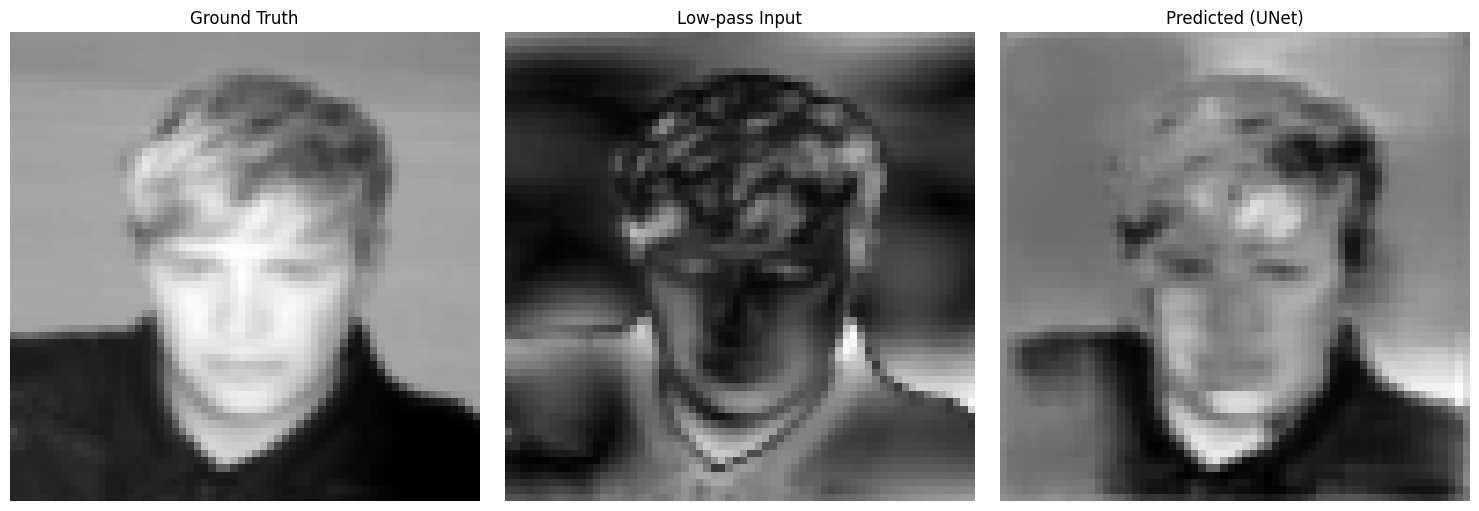

In [16]:
# pick a random sample from validation dataset
idx = 1  # You can change this to visualize different images

# Get the low-pass filtered input image and ground truth from validation set
lowpass_img_tensor, ground_truth_tensor, label= train_dataset[idx]

# Move tensors to appropriate device (if GPU used in training)
device = next(model.parameters()).device
lowpass_img_tensor = lowpass_img_tensor.unsqueeze(0).to(device)

# Predict the high-frequency restored image from the low-pass image
with torch.no_grad():
    predicted_tensor = model(lowpass_img_tensor)

# Move predictions back to CPU and remove batch/channel dimensions
lowpass_img = lowpass_img_tensor.cpu().squeeze().numpy()
predicted_img = predicted_tensor.cpu().squeeze().numpy()
ground_truth_img = ground_truth_tensor.squeeze().numpy()

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].imshow(ground_truth_img, cmap='gray')
axes[0].set_title("Ground Truth")
axes[0].axis('off')

axes[1].imshow(lowpass_img, cmap='gray')
axes[1].set_title("Low-pass Input")
axes[1].axis('off')

axes[2].imshow(predicted_img, cmap='gray')
axes[2].set_title("Predicted (UNet)")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [17]:
ssim_loss = SSIMLoss(data_range=1.0)

# Iterate through the dataset and calculate SSIM
ssim_values = []
ssim_values_pred = []

for img_in, img_out,label in val_loader:
    img_in, img_out = img_in.to(device), img_out.to(device)
    with torch.no_grad():
        img_pred = model(img_in)

    ssim = 1 - ssim_loss(img_in, img_out)  # SSIM = 1 - SSIMLoss
    ssim_pred = 1 - ssim_loss(img_out, img_pred)  # SSIM = 1 - SSIMLoss

    ssim_values.append(ssim.item())
    ssim_values_pred.append(ssim_pred.item())

# Calculate the average SSIM
average_ssim = sum(ssim_values) / len(ssim_values)
print(f"Average SSIM between input and output images: {average_ssim:.4f}")

average_ssim = sum(ssim_values_pred) / len(ssim_values_pred)
print(f"Average SSIM between input and pred images: {average_ssim:.4f}")

Average SSIM between input and output images: 0.0538
Average SSIM between input and pred images: 0.4811


In [7]:
# Classification network
class ClassificationNN(nn.Module):
    def __init__(self):
        super(ClassificationNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # raw logits

classification_model = ClassificationNN().to(device)
classification_model.load_state_dict(torch.load("classification_model.pth"))
classification_model.eval()

ClassificationNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [18]:
correct_input = 0
correct_output = 0
correct_predicted = 0
total = 0

classification_model.eval()

with torch.no_grad():
    for img_in, img_out, label in val_loader:
        img_in, img_out, label = img_in.to(device), img_out.to(device), label.to(device)

        # Classification on input images
        classification_output_input = classification_model(img_in)
        predicted_input = (torch.sigmoid(classification_output_input) > 0.5).float()
        correct_input += (predicted_input == label).sum().item()

        # Classification on output images
        classification_output_output = classification_model(img_out)
        predicted_output = (torch.sigmoid(classification_output_output) > 0.5).float()
        correct_output += (predicted_output == label).sum().item()

        # Classification on predicted images
        predicted_images = model(img_in)
        classification_output_predicted = classification_model(predicted_images)
        predicted_predicted = (torch.sigmoid(classification_output_predicted) > 0.5).float()
        correct_predicted += (predicted_predicted == label).sum().item()

        total += label.size(0)

accuracy_input = 100 * correct_input / total
accuracy_output = 100 * correct_output / total
accuracy_predicted = 100 * correct_predicted / total

print(f"Accuracy on Input Images: {accuracy_input:.2f}%")
print(f"Accuracy on Output Images: {accuracy_output:.2f}%")
print(f"Accuracy on Predicted Images: {accuracy_predicted:.2f}%")

Accuracy on Input Images: 52.00%
Accuracy on Output Images: 92.00%
Accuracy on Predicted Images: 81.67%
